In [1]:
import os.path as osp
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
from pykeen.evaluation import RankBasedEvaluator
from pykeen.triples import TriplesFactory
import torch
from tqdm import tqdm
import json

Change this cell to generate a report for other datasets/models:

In [52]:
MODEL_ID_rotate = 'rotate-otxtubeb' 
MODEL_ID_bioblpd = 'bioblpd-38uz9fjs'

In [37]:
#SHARED_DATA_DIR = Path("/home/jovyan/workbench-shared-folder/bioblp")
PROJ_DATA_DIR = Path("../data/")

##  Loading model and data

make a keyword based switching statement b/w rotate and bioblp-d

In [54]:
TEST = "test"
VALID = "valid"
TRAIN = "train"
ROTATE = "rotate"
BIOBLP_D = "bioblp_d"
MODELS = {
    ROTATE: MODEL_ID_rotate,
    BIOBLP_D: MODEL_ID_bioblpd
}

In [5]:
base_path = PROJ_DATA_DIR.joinpath(f"biokgb/models/{MODEL_ID}")
model_path = base_path.joinpath("trained_model.pkl")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = torch.load(model_path, map_location=torch.device(device))
train = TriplesFactory.from_path_binary(base_path.joinpath("training_triples"))

In [11]:
dummy_triples = 'biokg.links-dummy.csv'

df = pd.read_csv(graph_path.joinpath(test_triples), sep="\t", header=None)
df[:50].to_csv(graph_path.joinpath(dummy_triples), sep="\t", index=None, header=None)

In [8]:
graph_path = PROJ_DATA_DIR.joinpath('biokgb/graph')
valid_triples = 'biokg.links-valid.csv'
test_triples = 'biokg.links-test.csv'
#dummy_triples = 'biokg.links-dummy.csv'

valid, test, dummy = [TriplesFactory.from_path(graph_path.joinpath(f),
                                        entity_to_id=train.entity_to_id,
                                        relation_to_id=train.relation_to_id)
               for f in (valid_triples, test_triples, dummy_triples)]

#### utils

In [186]:
def obtain_filtered_triples(test_type, train_triples, valid_triples):
    if test_type == VALID:
        filtered_triples = [train_triples.mapped_triples]
    elif test_type == TEST:
        filtered_triples = [train_triples.mapped_triples, valid_triples.mapped_triples]
    return filtered_triples
    

Create test sets: 
D; D_b, D_r; 

All biokgb entities surprisingly have a relation - > D_r is an empty set

In [81]:
disease_descr_path = PROJ_DATA_DIR.joinpath("biokgb/properties/biokg_meshid_to_descr_name.tsv")
disease_metadata_path = PROJ_DATA_DIR.joinpath("biokgb/properties/biokg.metadata.disease.tsv")

# create a subset of biokg entities of type Disease 
diseases = pd.read_csv(disease_metadata_path, sep="\t", names=["disease", "rel", "node_type"])
disease_set = set(diseases.disease.values)
print(f"# Disease entities in larger biokg (pre-benchmark removal): {len(disease_set)}")

# create a set of disease entities for which we have text descriptions
disease_w_desc_df = pd.read_csv(disease_descr_path, sep="\t", names=["disease", "desc"])
disease_desc_set = set(disease_w_desc_df.disease.values)
print(f"# Disease entities in larger biokg (pre-benchmark removal) for which we have textual descriptions: {len(disease_desc_set)}")


# Disease entities in larger biokg (pre-benchmark removal): 11347
# Disease entities in larger biokg (pre-benchmark removal) for which we have textual descriptions: 11347


In [73]:
# Side note: all disease entities in Biokgb have decscriptions; because missing values were plugged with disease names
disease_w_desc_df["len"] = disease_w_desc_df["desc"].str.len()
disease_w_desc_df.len.describe()

count    11347.000000
mean       149.042743
std        156.370558
min          5.000000
25%         37.000000
50%         70.000000
75%        231.000000
max       1076.000000
Name: len, dtype: float64

In [82]:
biokgb_disease_ents = {k:v for k, v in train.entity_to_id.items() if k in disease_set}
print(list(biokgb_disease_ents.items())[:2])
biokgb_disease_ent_set = set(biokgb_disease_ents.keys())
biokgb_disease_ents_b = biokgb_disease_ent_set.intersection(disease_desc_set)
biokgb_disease_ents_r = biokgb_disease_ent_set.difference(biokgb_disease_ents_b)
print(len(biokgb_disease_ents), len(biokgb_disease_ents_b), len(biokgb_disease_ents_r))


[('C000600608', 1702), ('C000657245', 1703)]
5814 5814 0


In [86]:
train.relation_to_id

{'COMPLEX_IN_PATHWAY': 0,
 'COMPLEX_TOP_LEVEL_PATHWAY': 1,
 'DDI': 2,
 'DISEASE_GENETIC_DISORDER': 3,
 'DISEASE_PATHWAY_ASSOCIATION': 4,
 'DPI': 5,
 'DRUG_CARRIER': 6,
 'DRUG_DISEASE_ASSOCIATION': 7,
 'DRUG_ENZYME': 8,
 'DRUG_PATHWAY_ASSOCIATION': 9,
 'DRUG_TARGET': 10,
 'DRUG_TRANSPORTER': 11,
 'MEMBER_OF_COMPLEX': 12,
 'PPI': 13,
 'PROTEIN_DISEASE_ASSOCIATION': 14,
 'PROTEIN_PATHWAY_ASSOCIATION': 15,
 'RELATED_GENETIC_DISORDER': 16}

In [85]:
# relations containing diseases include -> 
dis_assoc_rels = {rel:rel_id for rel, rel_id in train.relation_to_id.items() if 'DISEASE' in rel}
dis_assoc_rels

{'DISEASE_GENETIC_DISORDER': 3,
 'DISEASE_PATHWAY_ASSOCIATION': 4,
 'DRUG_DISEASE_ASSOCIATION': 7,
 'PROTEIN_DISEASE_ASSOCIATION': 14}

In [175]:
# create set of triples
print(f"# triples originally in test: {test.num_triples}, valid: {valid.num_triples}")
test_triples_disease = test.new_with_restriction(relations=list(dis_assoc_rels.values()))
valid_triples_disease = valid.new_with_restriction(relations=list(dis_assoc_rels.values()))
print(f"# test triples with disease nodes: {test_triples_disease.num_triples}")
print(f"# valid triples with disease nodes: {valid_triples_disease.num_triples}")

# if reqd to partition triples conditional on entity nodes' availability of properties - use `invert_entity_selection` to excluse certain entities
test_triples_nondis = test.new_with_restriction(entities=biokgb_disease_ent_set, invert_entity_selection=True)
print(f"# test triples without disease nodes: {test_triples_nondis.num_triples}")
test.num_triples-(test_triples_nondis.num_triples+test_triples_disease.num_triples)

# triples originally in test: 185227, valid: 185226
# test triples with disease nodes: 17063
# valid triples with disease nodes: 17274
# test triples without disease nodes: 168164


0

In [166]:
# redundant sanity check to ensure rels in the filtered test_triples_disease pertain to disease ent type
x = valid_triples_disease.mapped_triples
y = x.view([-1, 3, 1])
ids = torch.ones(x.shape[0]).long()


In [183]:
rels = np.array(y.gather(1, ids.view(-1, 1, 1)).squeeze())
np.unique(rels, return_counts=True)

(array([ 3,  4,  7, 14]), array([ 282,  308, 6834, 9850]))

In [182]:
dis_assoc_rels


{'DISEASE_GENETIC_DISORDER': 3,
 'DISEASE_PATHWAY_ASSOCIATION': 4,
 'DRUG_DISEASE_ASSOCIATION': 7,
 'PROTEIN_DISEASE_ASSOCIATION': 14}

(array([ 282.,    0.,  308.,    0.,    0.,    0.,    0.,    0.,    0.,
           0., 6834.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0., 9850.]),
 array([ 3.        ,  3.36666667,  3.73333333,  4.1       ,  4.46666667,
         4.83333333,  5.2       ,  5.56666667,  5.93333333,  6.3       ,
         6.66666667,  7.03333333,  7.4       ,  7.76666667,  8.13333333,
         8.5       ,  8.86666667,  9.23333333,  9.6       ,  9.96666667,
        10.33333333, 10.7       , 11.06666667, 11.43333333, 11.8       ,
        12.16666667, 12.53333333, 12.9       , 13.26666667, 13.63333333,
        14.        ]),
 <BarContainer object of 30 artists>)

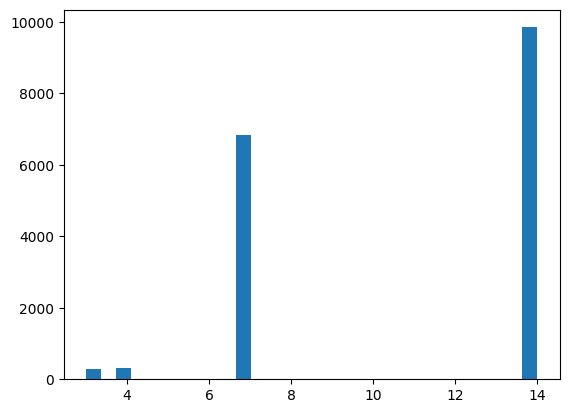

In [179]:
plt.hist(rels, bins = 30)

## Evaluation

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
evaluator = RankBasedEvaluator(filtered=True)

In [17]:
TEST_TRIPLES = dummy #test
results = evaluator.evaluate(model, TEST_TRIPLES.mapped_triples,
                             additional_filter_triples=[train.mapped_triples,
                                                        valid.mapped_triples])

Evaluating on cpu:   0%|          | 0.00/100 [00:00<?, ?triple/s]

In [14]:
results.get_metric('both.realistic.hits_at_1')

0.045

wandb logging

In [15]:
import wandb
wandb.login()
run = wandb.init(project="bioblp-jupyter-trial",
                 config={"entity": "discoverylab"})

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ········


wandb: Appending key for api.wandb.ai to your netrc file: /Users/mitrap/.netrc
wandb: Network error (SSLError), entering retry loop.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


wandb: Network error (SSLError), entering retry loop.


wandb: Network error resolved after 0:00:35.760049, resuming normal operation.


In [ ]:
#train, valid, test = load_triples_factories(DATA_PATH, DATASET)
log_wandb = False
#evaluator_kwargs={'batch_size': args.eval_batch_size},
result_tracker='wandb',
result_tracker_kwargs={
  'entity': 'discoverylab',
  'project': 'bioblp-eval',
  'tags': [model_name, study_name]
  'notes': args.notes,
  #'config': cli_args_dict,
  'offline': not args.log_wandb
}

wandb_kwargs = {"project": "bioblp-eval",
                "entity": "discoverylab",
                "tags": [study_name, study_prefix, name]}

#%%wandb
#wandb.log(valid_results_dict)

### Test on Valid dataset

create a function that evaluates and prints out scores for test, valid, valid_dis_restructed and test_dis_restricted triples

it should take a dictionary {test_set_name: test_set_triples}

In [193]:
triples_dict = {
    TEST: test,
    VALID: valid,
    TRAIN: train,
    'TEST_RESTRICTED_DIS': test_triples_disease,
    'TEST_EXCLUDING_DIS': test_triples_nondis,
    'VALID_RESTRICTED_DIS': valid_triples_disease,
    'DUMMY': dummy, 
}

def evaluate_lp_on_single_test_set(model, test_set_slug, all_rels=True, split_by_rels=False):
    if VALID in test_set_slug:
        test_type = VALID
    else:
        test_type = TEST

        evaluator = RankBasedEvaluator()   
    # should we filtering more triples in the disease restricted test sets?
    filtered_triples = obtain_filtered_triples(test_type=test_type, 
                                               train_triples=triples_dict[TRAIN],
                                               valid_triples=triples_dict[VALID]
                                              )
    results_all_rels = evaluator.evaluate(model, triples_dict[test_set_slug].mapped_triples,
                                     additional_filter_triples = filtered_triples)
    
    # if split_by_rels: add logic
    
    return results_all_rels


from typing import List
def evaluate_lp_on_multiple_test_sets(model, test_sets: List, all_rels = True, split_by_rels=False):
    results_all_rels = {} # for all rels, need to separately handle rel-wise eval
    for test_set in test_sets:
        print(f"Evaluating on test set: {test_set}")
        results_all_rels.update({test_set:  evaluate_lp_on_single_test_set(model=model, test_set_slug=test_set,
                                      all_rels=all_rels, split_by_rels=split_by_rels)})
    # consider if you wish to transform the dict to a more usable form here itself
    return results_all_rels

results_dict_all = evaluate_lp_on_multiple_test_sets(model, ['DUMMY'])
        
        

Evaluating on test set: DUMMY


Evaluating on cpu:   0%|          | 0.00/100 [00:00<?, ?triple/s]

In [210]:
results_dict_all

{'DUMMY': <pykeen.evaluation.rank_based_evaluator.RankBasedMetricResults at 0x7fa8288d75b0>}

In [ ]:
## also perform the above with rotate to compare

In [ ]:
# how to divide by degree?
# 1. compute a degree table for entities in train

In [200]:
training_df = pd.DataFrame(train.triples, columns=["src", "rel", "tgt"])
training_df[:2]

Reconstructing all label-based triples. This is expensive and rarely needed.


,src,rel,tgt
0,A0A075B6P5,MEMBER_OF_COMPLEX,R-HSA-1479277
1,A0A075B6P5,MEMBER_OF_COMPLEX,R-HSA-1591211


In [205]:
# not a nec step, but to ease computation, let's restrict the triples to disease node containg triples
training_df = training_df[training_df["rel"].isin(list(dis_assoc_rels.keys()))]
training_df.rel.value_counts()

PROTEIN_DISEASE_ASSOCIATION    89804
DRUG_DISEASE_ASSOCIATION       53426
DISEASE_GENETIC_DISORDER        4339
DISEASE_PATHWAY_ASSOCIATION     2945
Name: rel, dtype: int64

In [215]:
out_degree_df = training_df.groupby("src")["rel"].agg("count").reset_index()
out_degree_df.rename(columns={"src": "ent", "rel": "out_degree"}, inplace=True)
in_degree_df = training_df.groupby("tgt")["rel"].agg("count").reset_index()
in_degree_df.rename(columns={"tgt": "ent", "rel": "in_degree"}, inplace=True)


In [223]:
node_degree_df = out_degree_df.merge(in_degree_df, on="ent", how="outer")
node_degree_df = node_degree_df.fillna(0)

In [229]:
node_degree_df["degree"] = node_degree_df.in_degree+node_degree_df.out_degree


In [230]:
node_degree_df["is_disease"] = node_degree_df["ent"].apply(lambda x: x in biokgb_disease_ents)
node_degree_df[:2]

,ent,out_degree,in_degree,degree,is_disease
0,A0A096MJY4,1.0,0.0,1.0,False
1,A0A0G2JTR4,1.0,0.0,1.0,False


In [233]:
dis_node_degree_df = node_degree_df[node_degree_df.is_disease]
dis_node_degree_df[:2]

,ent,out_degree,in_degree,degree,is_disease
666,C000600608,4.0,4.0,8.0,True
678,C531816,5.0,7.0,12.0,True


In [236]:
dis_degree_dict = pd.Series(dis_node_degree_df.degree.values,index=dis_node_degree_df.ent).to_dict()
dis_degree_dict

{'C000600608': 8.0,
 'C531816': 12.0,
 'C535282': 3.0,
 'C535288': 6.0,
 'C535301': 8.0,
 'C535306': 24.0,
 'C535308': 8.0,
 'C535309': 7.0,
 'C535310': 15.0,
 'C535313': 11.0,
 'C535314': 10.0,
 'C535322': 7.0,
 'C535323': 5.0,
 'C535331': 4.0,
 'C535334': 10.0,
 'C535347': 2.0,
 'C535351': 4.0,
 'C535374': 5.0,
 'C535382': 12.0,
 'C535387': 3.0,
 'C535388': 11.0,
 'C535393': 15.0,
 'C535396': 5.0,
 'C535397': 2.0,
 'C535407': 6.0,
 'C535408': 9.0,
 'C535434': 8.0,
 'C535436': 16.0,
 'C535440': 3.0,
 'C535442': 21.0,
 'C535443': 18.0,
 'C535444': 16.0,
 'C535460': 7.0,
 'C535466': 2.0,
 'C535474': 4.0,
 'C535475': 6.0,
 'C535480': 4.0,
 'C535501': 10.0,
 'C535502': 5.0,
 'C535503': 6.0,
 'C535504': 9.0,
 'C535505': 10.0,
 'C535507': 55.0,
 'C535516': 10.0,
 'C535520': 25.0,
 'C535521': 9.0,
 'C535541': 6.0,
 'C535550': 3.0,
 'C535566': 5.0,
 'C535579': 20.0,
 'C535581': 5.0,
 'C535586': 13.0,
 'C535588': 7.0,
 'C535598': 10.0,
 'C535600': 8.0,
 'C535602': 3.0,
 'C535607': 30.0,
 'C535

In [243]:
# now bucket the test triples according to node degree
test_triples_dis_df = pd.DataFrame(test_triples_disease.triples, columns=["src", "rel", "tgt"])
def retrieve_node_degree(node, node2degree_dict):
    return node2degree_dict.get(node, 0)

test_triples_dis_df["src_dis_degree"] = test_triples_dis_df["src"].apply(lambda x: retrieve_node_degree(x, dis_degree_dict))
                                   

Reconstructing all label-based triples. This is expensive and rarely needed.


In [244]:
test_triples_dis_df["tgt_dis_degree"] = test_triples_dis_df["tgt"].apply(lambda x: retrieve_node_degree(x, dis_degree_dict))
test_triples_dis_df[:3]


,src,rel,tgt,src_dis_degree,tgt_dis_degree
0,A0A0G2K344,PROTEIN_DISEASE_ASSOCIATION,D000077192,0.0,464.0
1,A0A0G2K344,PROTEIN_DISEASE_ASSOCIATION,D000077274,0.0,56.0
2,A0A0G2K344,PROTEIN_DISEASE_ASSOCIATION,D009062,0.0,180.0


In [247]:
test_triples_dis_df["dis_degree"] = test_triples_dis_df.src_dis_degree + test_triples_dis_df.tgt_dis_degree
test_triples_dis_df.head()

,src,rel,tgt,src_dis_degree,tgt_dis_degree,dis_degree
0,A0A0G2K344,PROTEIN_DISEASE_ASSOCIATION,D000077192,0.0,464.0,464.0
1,A0A0G2K344,PROTEIN_DISEASE_ASSOCIATION,D000077274,0.0,56.0,56.0
2,A0A0G2K344,PROTEIN_DISEASE_ASSOCIATION,D009062,0.0,180.0,180.0
3,A0A0R4IKU3,PROTEIN_DISEASE_ASSOCIATION,D009361,0.0,599.0,599.0
4,A0A0R4IQZ2,PROTEIN_DISEASE_ASSOCIATION,D000686,0.0,38.0,38.0


In [248]:
test_triples_dis_df.dis_degree.describe()

count    17063.000000
mean       300.116451
std        422.864546
min          1.000000
25%         46.000000
50%        144.000000
75%        377.000000
max       2448.000000
Name: dis_degree, dtype: float64

In [269]:
quantiles_map.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [270]:
quant = np.linspace(0,1,num=10, endpoint=True)
quantiles = test_triples_dis_df["dis_degree"].quantile(quant)
quantiles_map = quantiles.reset_index()['dis_degree'].to_dict()
    
test_triples_dis_df["quantile"] = pd.cut(test_triples_dis_df["dis_degree"], quantiles, include_lowest=True, labels=list(quantiles_map.keys())[:-1])
test_triples_dis_df[:3]

,src,rel,tgt,src_dis_degree,tgt_dis_degree,dis_degree,quantile
0,A0A0G2K344,PROTEIN_DISEASE_ASSOCIATION,D000077192,0.0,464.0,464.0,7
1,A0A0G2K344,PROTEIN_DISEASE_ASSOCIATION,D000077274,0.0,56.0,56.0,2
2,A0A0G2K344,PROTEIN_DISEASE_ASSOCIATION,D009062,0.0,180.0,180.0,4


# Now do the metric computation within above buckets

(array([10561.,  3502.,  1593.,   398.,   151.,   169.,   289.,   196.,
            0.,   204.]),
 array([1.0000e+00, 2.4570e+02, 4.9040e+02, 7.3510e+02, 9.7980e+02,
        1.2245e+03, 1.4692e+03, 1.7139e+03, 1.9586e+03, 2.2033e+03,
        2.4480e+03]),
 <BarContainer object of 10 artists>)

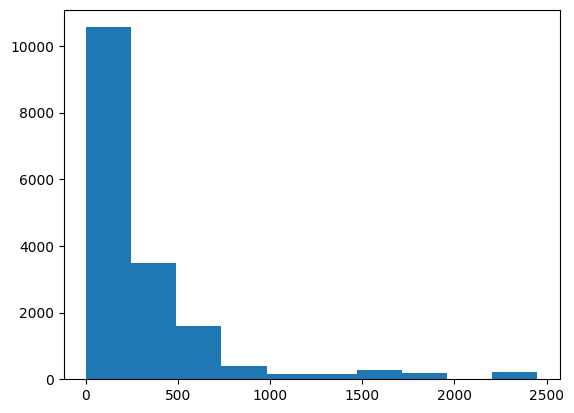

In [272]:
plt.hist(test_triples_dis_df.dis_degree)

In [19]:
TEST_TRIPLES = valid
evaluator = RankBasedEvaluator()
results_all_rels_valid = evaluator.evaluate(model, TEST_TRIPLES.mapped_triples,
                                     additional_filter_triples = [train.mapped_triples])
results_all_rels_valid.to_dict()['head']['realistic'].keys()
valid_results_dict = results_all_rels_valid.to_dict()['both']['realistic'] 
valid_results_dict

{'arithmetic_mean_rank': 1934.5975341796875,
 'adjusted_arithmetic_mean_rank_index': 0.9633914932884773,
 'count': 200.0,
 'standard_deviation': 10299.529296875,
 'adjusted_inverse_harmonic_mean_rank': 0.06330381254104638,
 'median_rank': 60.0,
 'adjusted_arithmetic_mean_rank': 0.03662674611016044,
 'median_absolute_deviation': 71.9062075975217,
 'inverse_arithmetic_mean_rank': 0.0005169033538550138,
 'z_geometric_mean_rank': 14.173646424325877,
 'inverse_geometric_mean_rank': 0.013784965500235558,
 'adjusted_geometric_mean_rank_index': 0.9981636875870081,
 'variance': 106080304.0,
 'harmonic_mean_rank': 15.770009169366327,
 'inverse_median_rank': 0.01666666753590107,
 'inverse_harmonic_mean_rank': 0.06341150403022766,
 'z_arithmetic_mean_rank': 23.597838915674995,
 'z_inverse_harmonic_mean_rank': 226.94119254994823,
 'geometric_mean_rank': 72.54280090332031,
 'hits_at_1': 0.015,
 'hits_at_3': 0.055,
 'hits_at_5': 0.09,
 'hits_at_10': 0.145,
 'z_hits_at_k': 210.63324858471807,
 'adjust

In [20]:
{f'hits_at_{k}': results_all_rels_valid.to_dict()['both']['realistic'][f'hits_at_{k}'] for k in [1,3,5,10]}

{'hits_at_1': 0.015,
 'hits_at_3': 0.055,
 'hits_at_5': 0.09,
 'hits_at_10': 0.145}

In [22]:
def make_results_dict(results, relation, relation_count):
    results = results.to_dict()
    results_dict = {'Relation': 'All' if not relation else relation,
                    'Count': relation_count,
                    'adjusted_mean_rank': results['both']['realistic']['adjusted_arithmetic_mean_rank'],
                    'mean_rank': results['both']['realistic']['arithmetic_mean_rank'],
                    'mean_reciprocal_rank': results['both']['realistic']['inverse_arithmetic_mean_rank'],
                    **{f'hits_at_{k}': results['both']['realistic'][f'hits_at_{k}'] for k in [1,3,5,10]}
                   }

    return results_dict

In [23]:
results_all_rels_dict = make_results_dict(results_all_rels, relation='All', relation_count=valid.num_triples)
results_all_rels_dict
#we again see a descripancy b/w valid and test set?

{'Relation': 'All',
 'Count': 185226,
 'adjusted_mean_rank': 0.03662674611016044,
 'mean_rank': 1934.5975341796875,
 'mean_reciprocal_rank': 0.0005169033538550138,
 'hits_at_1': 0.015,
 'hits_at_3': 0.055,
 'hits_at_5': 0.09,
 'hits_at_10': 0.145}

## Evaluating over specific. relation types

In [ ]:
#wandb.config.update({"model": "bioblp-d"})

In [184]:
TEST_TRIPLES = dummy #test #valid

result_dicts = []
for relation in tqdm(train.relation_to_id, desc='Evaluating over each relation'):
    triples_subset = TEST_TRIPLES.new_with_restriction(relations=[relation])
    if triples_subset.num_triples > 0:
        subset_result = evaluator.evaluate(model,
                                           triples_subset.mapped_triples, 
                                           additional_filter_triples=[train.mapped_triples],
                                           use_tqdm=False)
        result_dicts.append({'results': subset_result, 'relation': relation, 'count': triples_subset.num_triples})

Evaluating over each relation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:44<00:00,  2.61s/it]


In [185]:
results_df = pd.DataFrame([make_results_dict(d['results'], d['relation'], d['count']) for d in result_dicts])
results_df

,Relation,Count,adjusted_mean_rank,mean_rank,mean_reciprocal_rank,hits_at_1,hits_at_3,hits_at_5,hits_at_10
0,DDI,74,0.001472,77.662163,0.012876,0.006757,0.040541,0.067568,0.114865
1,DRUG_DISEASE_ASSOCIATION,5,0.009848,521.500000,0.001918,0.000000,0.000000,0.000000,0.000000
2,MEMBER_OF_COMPLEX,2,0.006073,321.750000,0.003108,0.250000,0.500000,0.500000,0.750000
3,PPI,3,0.853427,45246.417969,0.000022,0.000000,0.000000,0.000000,0.000000
4,PROTEIN_DISEASE_ASSOCIATION,5,0.065811,3480.699951,0.000287,0.000000,0.000000,0.000000,0.100000
5,PROTEIN_PATHWAY_ASSOCIATION,11,0.053725,2847.181885,0.000351,0.045455,0.136364,0.272727,0.363636


In [ ]:
results_df.to_csv('metrics/bioblp-d/results_val_by_rel.csv', index=None)

In [ ]:
%%wandb
metric_cols = list(results_df.columns)
metric_cols=[x for x in metric_cols if x != 'Relation']

for metric in metric_cols:
    rel_metric_dict = dict(zip(results_df.Relation, results_df[metric]))
    data = [[rel, val] for (rel, val) in rel_metric_dict.items()]
    table = wandb.Table(data=data, columns = ["relation", "value"])
    wandb.log({f"bar_chart_{metric}" : wandb.plot.bar(table, "relation",
                               "value", title=f"{metric} by relation")})

In [27]:
rel_results_dict = results_df.set_index('Relation').transpose().to_dict()
rel_results_dict

{'DDI': {'Count': 74.0,
  'adjusted_mean_rank': 0.0014717960510629911,
  'mean_rank': 77.66216278076172,
  'mean_reciprocal_rank': 0.012876283377408981,
  'hits_at_1': 0.006756756756756757,
  'hits_at_3': 0.04054054054054054,
  'hits_at_5': 0.06756756756756757,
  'hits_at_10': 0.11486486486486487},
 'DRUG_DISEASE_ASSOCIATION': {'Count': 5.0,
  'adjusted_mean_rank': 0.009848318892909212,
  'mean_rank': 521.5,
  'mean_reciprocal_rank': 0.001917545567266643,
  'hits_at_1': 0.0,
  'hits_at_3': 0.0,
  'hits_at_5': 0.0,
  'hits_at_10': 0.0},
 'MEMBER_OF_COMPLEX': {'Count': 2.0,
  'adjusted_mean_rank': 0.006072802855680099,
  'mean_rank': 321.75,
  'mean_reciprocal_rank': 0.0031080031767487526,
  'hits_at_1': 0.25,
  'hits_at_3': 0.5,
  'hits_at_5': 0.5,
  'hits_at_10': 0.75},
 'PPI': {'Count': 3.0,
  'adjusted_mean_rank': 0.8534268912446872,
  'mean_rank': 45246.41796875,
  'mean_reciprocal_rank': 2.2101197828305885e-05,
  'hits_at_1': 0.0,
  'hits_at_3': 0.0,
  'hits_at_5': 0.0,
  'hits_at_

In [28]:
restricted_rels_macro_performance = results_df[results_df.columns[2:]].mean(axis=0)
restricted_rels_macro_performance

adjusted_mean_rank         0.165059
mean_rank               8749.201995
mean_reciprocal_rank       0.003094
hits_at_1                  0.050369
hits_at_3                  0.112817
hits_at_5                  0.140049
hits_at_10                 0.221417
dtype: float64

Note that this is **not** the same as the original, unrestricted evaluation. When restricting by relation, the average above is a *macro-average*, where all relations are weighted equally. In the unrestricted scenario, we average over all triples, which is a *micro-average* where more frequent relations are weighted higher:

In [29]:
results_all_rels_dict

{'Relation': 'All',
 'Count': 185226,
 'adjusted_mean_rank': 0.03662674611016044,
 'mean_rank': 1934.5975341796875,
 'mean_reciprocal_rank': 0.0005169033538550138,
 'hits_at_1': 0.015,
 'hits_at_3': 0.055,
 'hits_at_5': 0.09,
 'hits_at_10': 0.145}

Since we have the triple counts for each relation, we can compute a micro-average instead:

In [31]:
restricted_rels_micro_performance = results_df[results_df.columns[2:]].mul(results_df['Count'], axis=0).sum(axis=0) / results_df['Count'].sum()
restricted_rels_micro_performance

adjusted_mean_rank         0.036506
mean_rank               1934.597544
mean_reciprocal_rank       0.009740
hits_at_1                  0.015000
hits_at_3                  0.055000
hits_at_5                  0.090000
hits_at_10                 0.145000
dtype: float64

## 

### previous stuff

How do MRR, H@k, and AMR correlate?

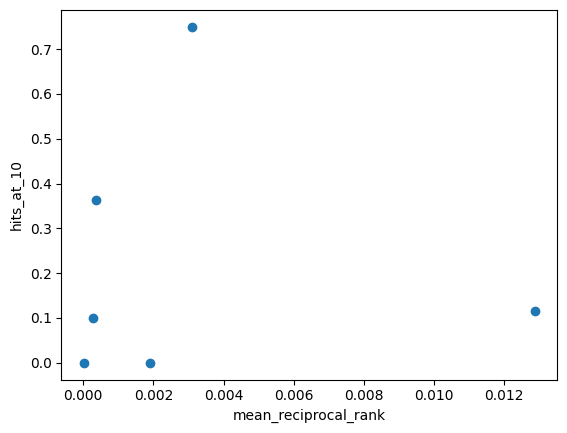

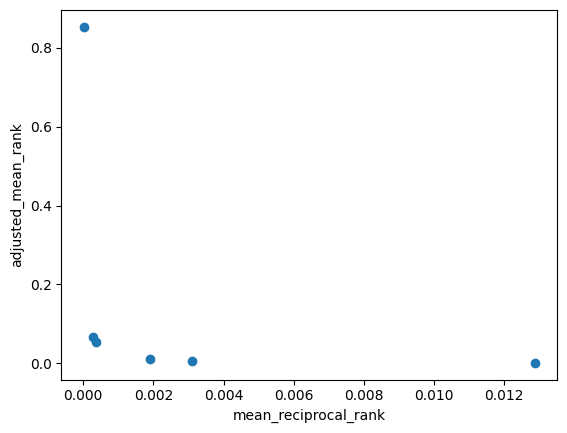

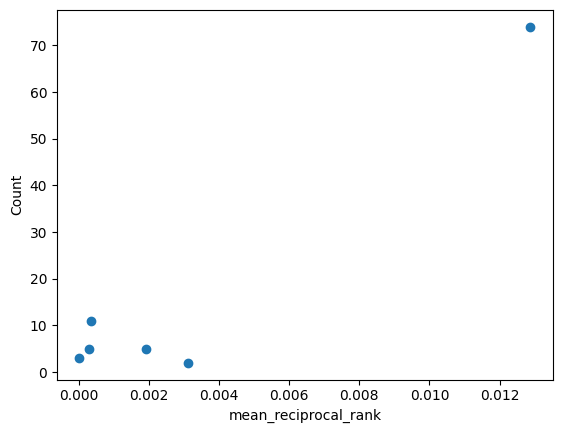

In [32]:
def plot_metric_pair(results_df, metric_1: str, metric_2: str):
    """Make a scatter plot with one link prediction metric in each axis."""
    plt.figure()
    plt.scatter(results_df[metric_1], results_df[metric_2])
    plt.xlabel(metric_1)
    plt.ylabel(metric_2)

plot_metric_pair(results_df, 'mean_reciprocal_rank', 'hits_at_10')
plot_metric_pair(results_df, 'mean_reciprocal_rank', 'adjusted_mean_rank')
plot_metric_pair(results_df, 'mean_reciprocal_rank', 'Count')

What are the relations where the model performs better?

In [33]:
def per_relation_plot(results_df, metric: str):
    """Make a bar plot of link prediction performance for each relation."""
    results_df[['Relation', metric]].sort_values(by=metric).plot.barh(x='Relation', figsize=(5, 5), grid=True)

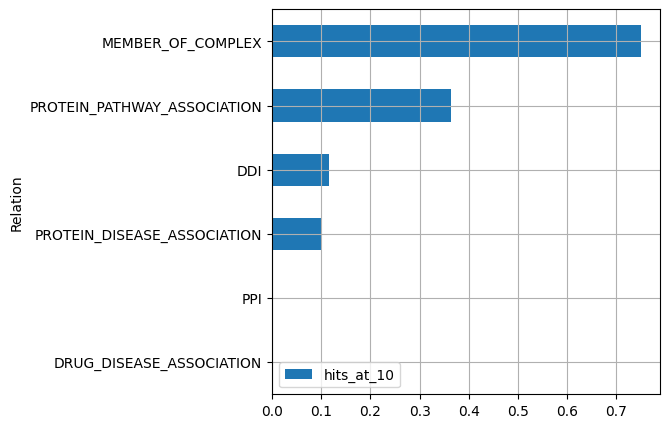

In [34]:
per_relation_plot(results_df, 'hits_at_10')

### Evaluating over specific entity and relation types
The source csv files contain the triples, plus extra information like the types of the entities involved in the triple. We will extract the type information.

We can see that restricting predictions over the correct domain and range of a relation only slightly increases the results.

In [ ]:
can you do an. analysis on degree....
compare rotate to this